## Overview 

`MatrixLMnet.jl` is a comprehensive package for both L<sub>1</sub> and L<sub>2</sub> penalized estimation in matrix linear models. It offers efficient and versatile methods for fitting sparse matrix linear models, particularly for analyzing structured high-throughput data. In this demonstration, we will explore the functionalities of this package through an easy-to-follow simulation study, showcasing its practical applications and user-friendly features.   
      
Within the scope of the matrix linear model framework, the model is articulated as follows:
$$Y = XBZ^T+E$$
Where     
- $Y_{n \times m}$ is the response matrix,   
- $X_{n \times p}$ is the matrix for main predictors,   
- $Z_{m \times q}$ denote the response attributes matrix based on a supervised knowledge,   
- $E_{n \times m}$ is the error term,   
- $B_{p \times q}$ is the matrix for main and interaction effects.,

In [1]:
using Pkg
Pkg.activate("../..") 

  Activating project at `C:\git\gregfa\mlm\MatrixLMnet.jl`


## Data Generation

In [2]:
using MatrixLMnet
using DataFrames
using Plots

In this example,  we set up a simulation for matrix linear models. 
We generate a dataset containing two categorical variables and four numerical variables.

In [3]:
# Define number of samples in the predictors dataset
n = 100

# Generate data with one categorical variables and 3 numerical variables.
dfX = hcat(DataFrame(
    catvar1=rand(["A", "B", "C", "D"], n)), 
    DataFrame(rand(n,3), ["numvar1", "numvar2", "numvar3"]));

first(dfX, 3)

Row,catvar1,numvar1,numvar2,numvar3
,String,Float64,Float64,Float64
1,A,0.0272858,0.880826,0.284163
2,B,0.571666,0.414586,0.406994
3,A,0.151188,0.680321,0.424177


We need to create a design matrix **X** form the dataframe *dfX*. We can use the `design_matrix()` function from the package `MatrixLM.jl`. For more information about its usage and the macro `@mlmformula` please refer to its [documentation](https://senresearch.github.io/MatrixLM.jl/stable/).      
First, we need to select the contrast coding of our categorical variable.

In [4]:
# Define constrast coding for catvar 
levels_catvar1 = sort(unique(dfX.catvar1));
X_ctrst = Dict(
             :catvar1 => MatrixLMnet.MatrixLM.StatsModels.DummyCoding(levels = levels_catvar1),
           );

Let convert the dataframe *dfX* to the predictor matrix **X** using `design_matrix()`:

In [5]:
X = design_matrix(@mlmformula(1 + catvar1 + numvar1 + numvar2 + numvar3), dfX, X_ctrst);

 We also define **Z**, a random matrix with dimensions *m* by *q*, and **B**, a matrix of random integers between -5 and 5 with dimensions matching **X** and **Z**. According the matrix linear models framework, the response matrix **Y** is calculated as the product of **X**, **B**, and the transpose of **Z**, with an added noise matrix **E**.   
 Finally, we construct a `RawData` object named `dat``, which comprises the response matrix **Y** and the predictor matrices **X** and **Z**.

In [6]:
# Number of predictors
p = size(X)[2]
# Number of column responses
m = 250
# Number of column covariates
q = 20

Z = rand(m,q)
B = rand(-5:5,p,q)
E = randn(n,m)
Y = X*B*transpose(Z)+E

# Construct a RawData object
dat = RawData(Response(Y), Predictors(X, Z));

## Model Estimation

### Hyper parameters

Create a 1d array of lambda penalties values to fit the estimates. If the lambdas are not in descending order, they will be automatically sorted by `mlmnet`.

In [7]:
lambdas = reverse(1.5.^(1:3:10))

4-element Vector{Float64}:
 57.6650390625
 17.0859375
  5.0625
  1.5

Create a 1d array of alpha parameter penalties values that determine the penalties mix between L<sub>1</sub> and L<sub>2</sub> to fit the estimates according to the Elastic Net penalization method.  In the case of Lasso regression (L<sub>1</sub> regularization), alpha should be 1, and 0 for Ridge regression (L<sub>2</sub> regularization). If the alphas are not in descending order, they will be automatically sorted by `mlmnet`.

In [8]:
alphas = reverse(collect(0:0.5:1));

If `alphas` argument is omitted, a Lasso regression will be applied which is equivalent to `alphas = [1]`.  

### Elastic Net penalization algorithms selection

The algorithms available for fitting Elastic Net penalized estimates in `mlmnet` function come with customizable keyword arguments for fine-tuning. 
The `method` keyword argument selects the function implementing the Elastic-net penalty estimation method. The default method is **ista**; alternative options include **fista**, **fista_bt**, **admm**, and **cd**.    
*Note: Any irrelevant arguments will simply be disregarded.*

|Algorithm                     | Methods     | Parameter     | Default  | Description                                                                     |
|------------------------------|-------------|---------------|----------|--------------------------------------------------------------------------------:|
|**Coordinate Descent**        | "cd"        | `isRandom`    | true     | Determines the use of either random or cyclic updates                           |
|**Active Coordinate Descent** | "cd_active" | `isRandom`    | true     | Specifies the choice between random and cyclic updates                          |
|**ISTA** with fixed step size | "ista"      | `stepsize`    | 0.01     | Sets a fixed step size for updates                                              |
|                              |             | `setStepsize` | true     | Decides if the fixed step size is to be computed, overriding `stepsize`         |
|**FISTA** with fixed step size| "fista"     | `stepsize`    | 0.01     | Establishes a fixed step size for updates                                       |
|                              |             | `setStepsize` | true     | Determines if the fixed step size should be recalculated, overriding `stepsize` |
|**FISTA** with backtracking   | "fista_bt"  | `stepsize`    | 0.01     | Indicates the initial step size for updates                                     |
|                              |             | `gamma`       | 0.5      | The multiplier for step size during backtracking/line search                    |
|**ADMM**                      | "admm"      | `rho`         | 1.0      | The parameter influencing ADMM tuning                                           |
|                              |             | `setRho`      | true     | Decides whether the ADMM tuning parameter `rho` is to be auto-calculated        |
|                              |             | `tau_incr`    | 2.0      | The factor for increasing the ADMM tuning parameter                             |
|                              |             | `tau_decr`    | 2.0      | The factor for decreasing the ADMM tuning parameter                             |
|                              |             | `mu`          | 10.0     | The parameter influencing the balance between primal and dual residuals         |


### Estimation

In this example, we will use the 'fista' method for our estimation process. 
Given that our design matrix already incorporates an intercept, we specify that there is no need to add an additional intercept to the design matrices **X** and **Z**.

In [9]:
est_fista = mlmnet(
    dat, 
    [lambdas[1]], [alphas[1]], 
    method = "fista", 
    addZIntercept = false, addXIntercept = false, isVerbose = false);

Let's delve into the structure returned by the `mlmnet()` function. The result, `est_fista`, is of the `Mlmnet` type, a structured data type encompassing the next key fields:

- `B`: This is the estimated coefficient matrix. It is a four-dimensional matrix where the dimensions represent rows, columns, lambda indices, and alpha indices.
- `lambdas`: A vector containing the lambda values utilized in the estimation.
- `alphas`: A vector of the alpha values used.
- `data`: A `RawData` object that holds the original dataset used for the estimation.

For instance, let execute the command with all lambdas and alphas values:

In [10]:
est_fista = mlmnet(
    dat, 
    lambdas, alphas, 
    method = "fista", 
    addZIntercept = false, addXIntercept = false, isVerbose = false);

In this case, the matrix `B` would have dimensions of (7, 20, 4, 3). These dimensions correspond to the estimated coefficients across each of the 4 lambda values and 3 alpha values, offering a comprehensive view of the coefficient variations influenced by different regularization parameters.

### Cross Validation 

Cross-validation within the `mlmnet` framework is implemented by the `mlmnet_cv` function. This function offers flexibility in defining the folds for cross-validation. We can either specify the row and column folds of `Y` manually as 1D arrays containing row or column indices, or we can simply specify the desired number of folds. When a specific number of folds is indicated, `mlmnet_cv` will generate disjoint folds of approximately equal size using the `make_folds` function. Setting the number of row or column folds to `1` implies the use of all rows or columns of `Y` in each fold.

One key benefit of manually inputting row and/or column folds is the user's ability to stratify or control the nature of the folds. For instance, `make_folds_conds` can be employed to create folds based on a set of categorical conditions, ensuring each condition is equally represented across folds. Additionally, cross-validation computations are executed in parallel whenever feasible, enhancing efficiency. To incorporate non-standard behaviors in `mlmnet`, we can pass the relevant keyword arguments directly into `mlmnet_cv`.

In the following call, `mlmnet_cv` is configured to create 10 disjoint row folds while utilizing all columns of `Y` in each fold, as denoted by the 1:

In [11]:
est_fista_cv = mlmnet_cv(
    dat, 
    lambdas, alphas,
    10, 1, 
    method = "fista",  
    addZIntercept = false, addXIntercept = false, isVerbose = false);

*Note: The `dig` keyword argument in `mlmnet_cv` is used to set the precision level for computing the percentage of zero coefficients. Its default value is `12`, allowing for detailed precision in the calculations.*

The function returns an `Mlmnet_cv` object, which contains an array of the Mlmnet objects for each fold (`MLMNets`); the lambda penalty values used (`lambdas`); the row and column folds (`rowFolds` and `colFolds`); an array of the mean-squared error for each fold (`mse`); and an array of the proportion of zero interaction effects for each fold (`propZero`). The keyword argument `dig` in `mlmnet_cv` adjusts the level of precision when calculating the percent of zero coefficients. It defaults to `12`.

The output from the `mlmnet_cv()` function yields an `Mlmnet_cv` object. This object encompasses the following components:

- `MLMNets`: An array consisting of the `Mlmnet` objects corresponding to each fold.
- `lambdas`: The array of lambda penalty values applied during the estimati
- `alphas`: The array of alpha penalty values applied during the estimation.on.
- `rowFolds` and `colFolds`: Arrays representing the row and column folds used in cross-validation.
- `mse`: An array detailing the mean-squared error for each individual fold.
- `propZero`: An array capturing the proportion of zero interaction effects in each ft `12`."

`mlmnet_cv_summary` presents a table summarizing the average mean-squared error (MSE) and the proportion of zero coefficients for each pair of (lambda, alpha) values across all folds. The optimal (lambda, alpha) could be selected as the one that minimizes the MSE. Alternatively, it might be chosen according to a specific, pre-defined proportion of zeros desired in the coefficient estimates.

In [12]:
mlmnet_cv_summary(est_fista_cv)

Row,𝜆_𝛼_Index,Lambda,Alpha,AvgMSE,StdMSE,AvgPropZero
,Tuple…,Float64,Float64,Float64,Float64,Float64
1,"(1, 1)",57.665,1.0,18.7416,1.87917,0.679286
2,"(2, 1)",17.0859,1.0,6.46943,0.57586,0.42
3,"(3, 1)",5.0625,1.0,2.49412,0.290205,0.178571
4,"(4, 1)",1.5,1.0,1.22069,0.071585,0.0671429
5,"(1, 2)",57.665,0.5,32006.4,3798.02,0.0
6,"(2, 2)",17.0859,0.5,6609.07,862.572,0.0
7,"(3, 2)",5.0625,0.5,829.012,123.063,0.005
8,"(4, 2)",1.5,0.5,92.8234,14.5585,0.005
9,"(1, 3)",57.665,0.0,61511.1,7044.65,0.0


The `lambda_min` function returns the summary information for the lambdas that correspond to the minimum average test MSE across folds and the MSE that is one standard error greater.

In [13]:
lambda_min(est_fista_cv)

Row,Name,Index,Lambda,Alpha,AvgMSE,AvgPropZero
,String,Tuple…,Float64,Float64,Float64,Float64
1,"(𝜆, 𝛼)_min","(4, 1)",1.5,1.0,1.22069,0.0671429
2,"(𝜆, 𝛼)_min1se","(4, 1)",1.5,1.0,1.22069,0.0671429


## Model predictions and residuals

The 4D array of coefficient estimates is returned by the function `coef(est)`, where `est` is the results of the function `mlmnet`. 

The command `est_fista.B` or `coef(est_fista)` retrieves the full array containing the estimated coefficients.    
Let display the residual errors heatmap based on our estimation.

To compare the estimated coefficients with the original matrix **B**, we will visualize the matrices using heatmaps. This graphical representation allows us to readily see differences and similarities between the two.

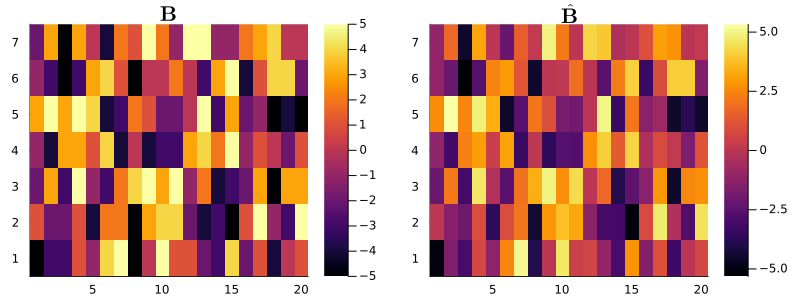

In [14]:
plot(
    heatmap(B[end:-1:1, :], 
            size = (800, 300)),     
    heatmap(est_fista.B[end:-1:1, :, 4, 1], 
            size = (800, 300)), 
            # clims = (-5, 5)),     
    title = ["\$ \\mathbf{B}\$" "\$ \\mathbf{\\hat{B}}\$"]
)

To obtain predicted values and residuals, one can use `predict` and `resid` respectively. 
By default, these functions use the data from the model fit, but alternative data can be supplied: `newPredictors` (a `Predictors` object) for `predict`, and `newData` (a `RawData` object) for `resid`. For added convenience, `fitted(est)` returns the fitted values by default when calling `predict`.

Let's employ the same visualization method to compare the predicted values with the original **Y** response matrix. This allows us to gauge the accuracy of our model predictions.

In [15]:
preds = predict(est_fista, lambdas[4], alphas[1]); # Prediction value

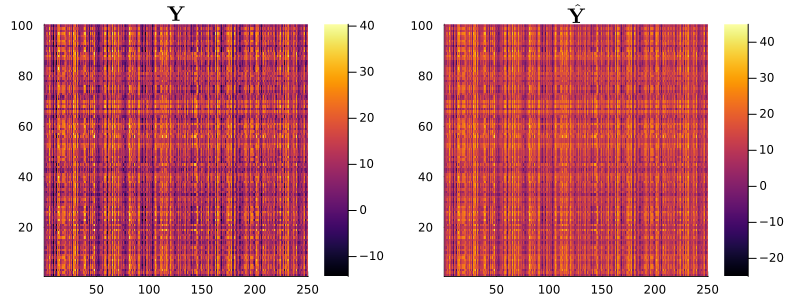

In [16]:
plot(
    heatmap(Y[end:-1:1, :], 
            size = (800, 300)),     
    heatmap(preds[end:-1:1, :], 
            size = (800, 300), 
            clims = (-25, 45)
            ),     
    title = ["\$ \\mathbf{Y}\$" "\$ \\mathbf{\\hat{Y}}\$"],
)

The `resid()` function provides us with the ability to compute residuals for each observation, helping you evaluate the discrepancy between the model's predictions and the actual data.

In [17]:
resids= resid(est_fista, lambdas[4], alphas[1]); 

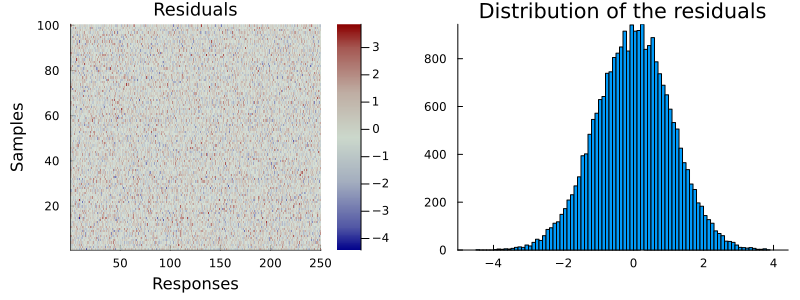

In [18]:
plot(
    heatmap(
        resids[end:-1:1, :], 
        color = cgrad(:bluesreds,[0.1, 0.3, 0.7, 0.9], alpha = 0.8),
        title = "Residual errors",
        titlefontsize = 12, grid = false,
        xlabel = "Responses",
        ylabel = "Samples",
        size = (500, 250),
        left_margin = (5,:mm), bottom_margin = (5,:mm),
    ),
    histogram(
        (reshape(resids,250*100,1)),
        grid  = false,
        label = "",
        size = (800, 300)
    ),     
    title = ["Residuals" "Distribution of the residuals"]
)

Additional details can be found in the documentation for specific functions.